In [1]:
import torch
import numpy
import math
import numpy as np
from scipy.stats import multivariate_normal as normal
import matplotlib.pyplot as plt

In [2]:
class one_time_net(torch.nn.Module):
    def __init__(self,d,acti):
        super(one_time_net,self).__init__()
        self.n_neuron=[d,d+10,d+10,1]
        self.norm=torch.nn.BatchNorm1d(self.n_neuron[0])
        self.acti=acti
        #self.layer1=self._one_layer(self.n_neuron[0],self.n_neuron[1],torch.nn.ReLU())
        #self.layer2=self._one_layer(self.n_neuron[1],self.n_neuron[2],torch.nn.ReLU())
        #self.layer3=self._one_layer(self.n_neuron[2],self.n_neuron[3],None)
        self.layers=torch.nn.ModuleList([self._one_layer(self.n_neuron[0],self.n_neuron[1],torch.nn.ReLU()),self._one_layer(self.n_neuron[1],self.n_neuron[2],torch.nn.ReLU()),
                                        self._one_layer(self.n_neuron[2],self.n_neuron[3],acti)])
    def _one_layer(self,input_dim,output_dim,activation_fn=torch.nn.ReLU()):
        if activation_fn != None:
            return torch.nn.Sequential(torch.nn.Linear(input_dim,output_dim),torch.nn.BatchNorm1d(output_dim),activation_fn)
        else:
            return torch.nn.Sequential(torch.nn.Linear(input_dim,output_dim),torch.nn.BatchNorm1d(output_dim))
    def forward(self,x):
        norm=self.norm(x)
        l1=self.layers[0](x)
        l2=self.layers[1](l1)
        out=self.layers[2](l2)
        return out       

In [3]:
#model parameters
r=0.03 #interest rate
mu=0.07 #average return
sigma=0.3 #volatility
#lam=1
#jump=-0.1
T=.2 #terminal time
c1=1.2 #terminal utility parameter1
c2=0 #terminal utility parameter2
xref=0 #terminal utility parameter3
gamma=0.5 #risk aversion
d=0 #lower bound of strategy
u=1 #upper bound of strategy
zmin=0
zmax=200
N=10
deltat=T/N

In [4]:
class wealthmodel(object):
    def __init__(self,mu,r,sigma,deltat):
        self.mu=mu
        self.r=r
        self.sigma=sigma
        self.deltat=deltat
        self.sqrt=np.sqrt(deltat)
        #self.noise=torch.distributions.normal.Normal(torch.tensor([0.0]),torch.tensor([1.0]))
    def sample(self,w,pi,batch_size):
        noise=torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(batch_size),torch.eye(batch_size))
        next_w=w*((self.mu-self.r)*self.deltat*pi+self.sigma*pi*self.sqrt*noise.sample().reshape([batch_size,1]))+w
        return next_w
    def utility(self,w):
        return w**(1-gamma)/(1-gamma)*(w<xref).float()+(c1*w**(1-gamma)/(1-gamma)+c2)*(w>=xref).float()

In [12]:
batch_size=256
lr=5e-4
model=wealthmodel(mu,r,sigma,deltat)
N_iter=8000*2
values=[]
controls=[]
for i in range(N):
    values.append(one_time_net(2,torch.nn.ReLU()))
    controls.append(one_time_net(1,torch.nn.Sigmoid()))
voptims=[]
coptims=[]
for i in range(N):
    voptims.append(torch.optim.Adam(values[i].parameters(),lr=lr))
    coptims.append(torch.optim.Adam(controls[i].parameters(),lr=lr))
criterion=torch.nn.MSELoss()

In [13]:
for i in range(N_iter):
    w=(zmax-zmin)*torch.rand([batch_size,1])+zmin
    strategy=(u-d)*controls[-1](w)+d
    next_w=model.sample(w,strategy,batch_size)
    target=model.utility(next_w)
    Qloss=criterion(values[-1](torch.cat([w,strategy],1)),target.detach())
    voptims[-1].zero_grad()
    Qloss.backward()
    voptims[-1].step()
    policy_loss=-1*values[-1](torch.cat([w,(u-d)*controls[-1](w)+d],1)).mean()
    coptims[-1].zero_grad()
    policy_loss.backward()
    coptims[-1].step()
for t in reversed(range(N-1)):
    for i in range(N_iter):
        w=(zmax-zmin)*torch.rand([batch_size,1])+zmin
        strategy=(u-d)*controls[t](w)+d
        next_w=model.sample(w,strategy,batch_size)
        next_strategy=(u-d)*controls[t+1](next_w)+d
        target=values[t+1](torch.cat([next_w,next_strategy],1))
        Qloss=criterion(values[t](torch.cat([w,strategy],1)),target.detach())
        voptims[t].zero_grad()
        Qloss.backward()
        voptims[t].step()
        policy_loss=-1*values[t](torch.cat([w,(u-d)*controls[t](w)+d],1)).mean()
        coptims[t].zero_grad()
        policy_loss.backward()
        coptims[t].step()    

In [14]:
zgrid=np.linspace(zmin,zmax,1001)
z=torch.tensor(zgrid).reshape([-1,1]).float()
pi=(u-d)*controls[-1](z)+d
v=values[0](torch.cat([z,pi],1))
eta=mu-r
pi0=eta/sigma**2/gamma
pistar=d*(pi0<d)+pi0*(pi0>=d)*(pi0<=u)+u*(pi0>u)
AA=eta*pistar-gamma/2*pistar**2*sigma**2

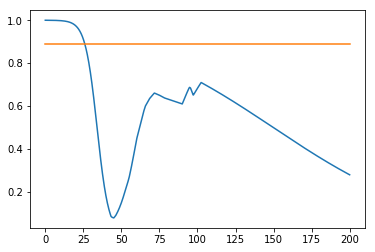

In [15]:
plt.plot(zgrid,pi.detach().numpy().reshape([-1,]))
plt.plot(zgrid,pi0*np.ones(shape=zgrid.shape))

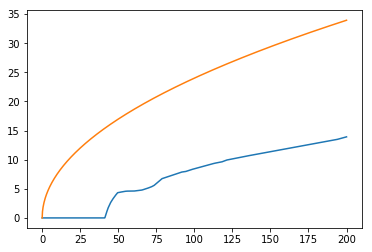

In [16]:
plt.plot(zgrid,v.detach().numpy().reshape([-1,]))
plt.plot(zgrid,model.utility(z).detach().numpy().reshape([-1,])*np.exp(-1*AA*t))